# W207 Group Project - What's Cooking?

Group members: Daniel Volk, Aaron Yuen

Kaggle competition link: https://www.kaggle.com/c/whats-cooking

## Business Understanding

#### Description from Kaggle:

Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

#### What problem are we trying to solve?

The problem at hand is to categorize the cuisine of a recipe based on the provided list of ingredients. This competition was hosted by Yummly, a company that builds a mobile app and website that provides recipe recommendations personalized to the individual's tastes. This is a multi-class classification problem where the input is a list of strings (ingredients) and the output we are trying to predict is one of the various classes of cuisine. 

## Data Understanding

#### Library Imports

In [2]:
# Loading all relevant libraries
%matplotlib inline
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import re

matplotlib.rc('font', **{'weight' : 'bold', 'size':10} )

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, f1_score, auc
import string
import seaborn as sn
from nltk.stem import WordNetLemmatizer

#### Data Loading

The provided sources of data from the competition are:

1. train.json - Includes both the list of ingredients as features and the cuisine as the class
2. test.json - Includes only the list of ingredients as features. The cuisine (e.g. the class) is not present.


In [3]:
# Read train and test dataset from the provided JSONs
train = pd.read_json("data/train.json")
test = pd.read_json("data/test.json")

# Separate to raw features dataframe
X_train_all = train["ingredients"]
X_test = test["ingredients"]

# Separate label dataframe
y_train_all = train["cuisine"]

In [4]:
print "Shape of features:", X_train_all.shape
print "Shape of labels:", y_train_all.shape

Shape of features: (39774,)
Shape of labels: (39774,)


#### Example Features and Labels

In [5]:
print "First 10 example features from the training set"
print X_train_all.head(10)
print ""

print "First 10 example labels from the training set"
print y_train_all.head(10)
print ""

print "First 10 example features from the test set"
print X_test.head(10)
print ""

First 10 example features from the training set
0    [romaine lettuce, black olives, grape tomatoes...
1    [plain flour, ground pepper, salt, tomatoes, g...
2    [eggs, pepper, salt, mayonaise, cooking oil, g...
3                  [water, vegetable oil, wheat, salt]
4    [black pepper, shallots, cornflour, cayenne pe...
5    [plain flour, sugar, butter, eggs, fresh ginge...
6    [olive oil, salt, medium shrimp, pepper, garli...
7    [sugar, pistachio nuts, white almond bark, flo...
8    [olive oil, purple onion, fresh pineapple, por...
9    [chopped tomatoes, fresh basil, garlic, extra-...
Name: ingredients, dtype: object

First 10 example labels from the training set
0          greek
1    southern_us
2       filipino
3         indian
4         indian
5       jamaican
6        spanish
7        italian
8        mexican
9        italian
Name: cuisine, dtype: object

First 10 example features from the test set
0    [baking powder, eggs, all-purpose flour, raisi...
1    [sugar, egg yolks,

In [6]:
# Check for nulls in the ingredients column
print "The number of examples where ingredients is null is", (X_train_all.isnull()).sum()

The number of examples where ingredients is null is 0


In [4]:
pd.DataFrame(train)[['ingredients', 'cuisine']].head(10)

,ingredients,cuisine
0,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]",greek
1,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]",southern_us
2,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]",filipino
3,"[water, vegetable oil, wheat, salt]",indian
4,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]",indian
5,"[plain flour, sugar, butter, eggs, fresh ginger root, salt, ground cinnamon, milk, vanilla extract, ground ginger, powdered sugar, baking powder]",jamaican
6,"[olive oil, salt, medium shrimp, pepper, garlic, chopped cilantro, jalapeno chilies, flat leaf parsley, skirt steak, white vinegar, sea salt, bay leaf, chorizo sausage]",spanish
7,"[sugar, pistachio nuts, white almond bark, flour, vanilla extract, olive oil, almond extract, eggs, baking powder, dried cranberries]",italian
8,"[olive oil, purple onion, fresh pineapple, pork, poblano peppers, corn tortillas, cheddar cheese, ground black pepper, salt, iceberg lettuce, lime, jalapeno chilies, chopped cilantro fresh]",mexican
9,"[chopped tomatoes, fresh basil, garlic, extra-virgin olive oil, kosher salt, flat leaf parsley]",italian


## Exploratory Analysis

#### Distribution of Training Classes

Here we can see that there is a high imbalance of classes, with majority of the cuisine to be Italian, Mexican, and Southern US. We'll need to ensure in the data preparation step that these are more balanced before training, or make sure that if we don't handle it ourselves, the model already rebalances the classes based on label frequencies (e.g. like in LogisticRegression).

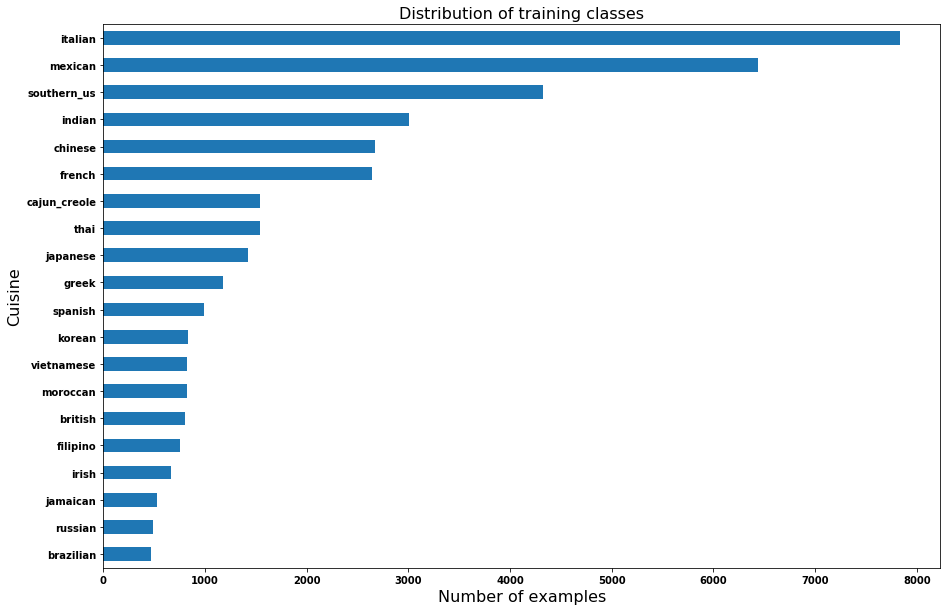

In [5]:
# Plot distribution of training classes
plt.figure(figsize=(15,10))
f = y_values = y_train_all.value_counts().plot(kind='barh')
f.invert_yaxis()
plt.title("Distribution of training classes", fontsize=16)
plt.ylabel("Cuisine", fontsize=16)
plt.xlabel("Number of examples", fontsize=16)

#### Number of Ingredients per Recipe

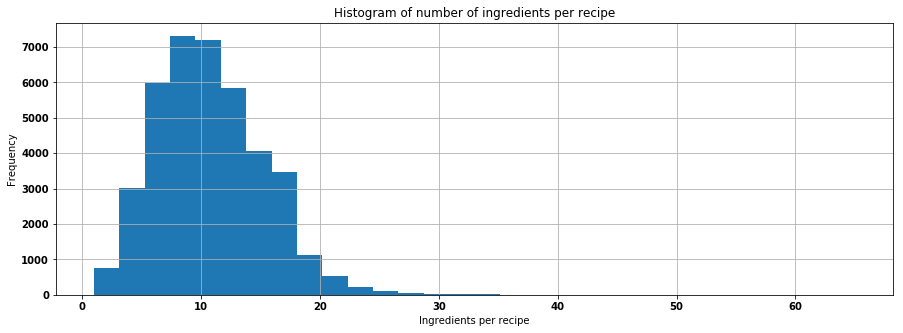

In [6]:
plt.figure(figsize=(15,5))
f = X_train_all.apply(len).hist(bins=30)
plt.title("Histogram of number of ingredients per recipe")
plt.ylabel("Frequency")
plt.xlabel("Ingredients per recipe")

#### Most Common Ingredients - All Cuisines

The top ingredients seem to be very common ingredients like salt, sugar, oil, etc. which may not be cusine-specific. These features could potentially be ruled out (or let the model feature-select). Here we can also see that there are similar ingredients that should be deduplicated (e.g. kosher salt and salt, olive oil and oil).

In [7]:
# For each row, go through each ingredient and create a cuisine-ingredient pair
ing_cuisine_pair = []
for i in xrange(X_train_all.shape[0]):
    for ingredient in X_train_all[i]:
        ing_cuisine_pair.append([y_train_all[i], ingredient])

ing_cuisine = pd.DataFrame(ing_cuisine_pair, columns=['cuisine', 'ingredient'])

NameError: name 'xrange' is not defined

NameError: name 'ing_cuisine' is not defined

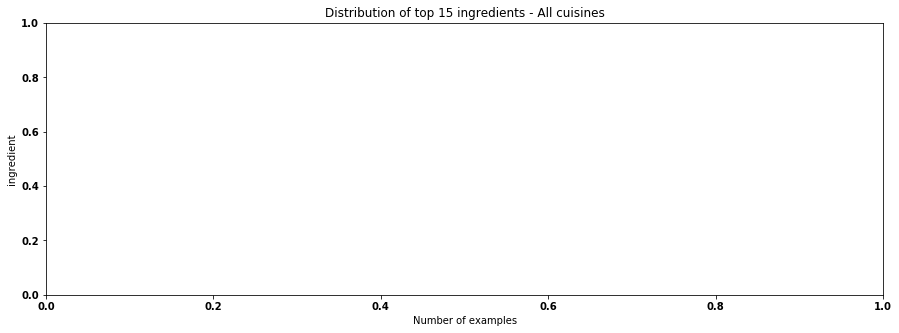

In [8]:
plt.figure(figsize=(15,5))
plt.title("Distribution of top 15 ingredients - All cuisines")
plt.ylabel("ingredient")
plt.xlabel("Number of examples")
f = ing_cuisine['ingredient'].value_counts()[:15].plot(kind='barh')
f.invert_yaxis()

#### Most Common Ingredients - By Cuisine

Similarly, here by cuisine the top ingredients are common ingredients like salt, but we start to see some cuisine-specific incredients like jalapeno chilies for Mexican and soy sauce for Chinese. Below are the top ingredients by four cuisines (out of the 20 cuisines).

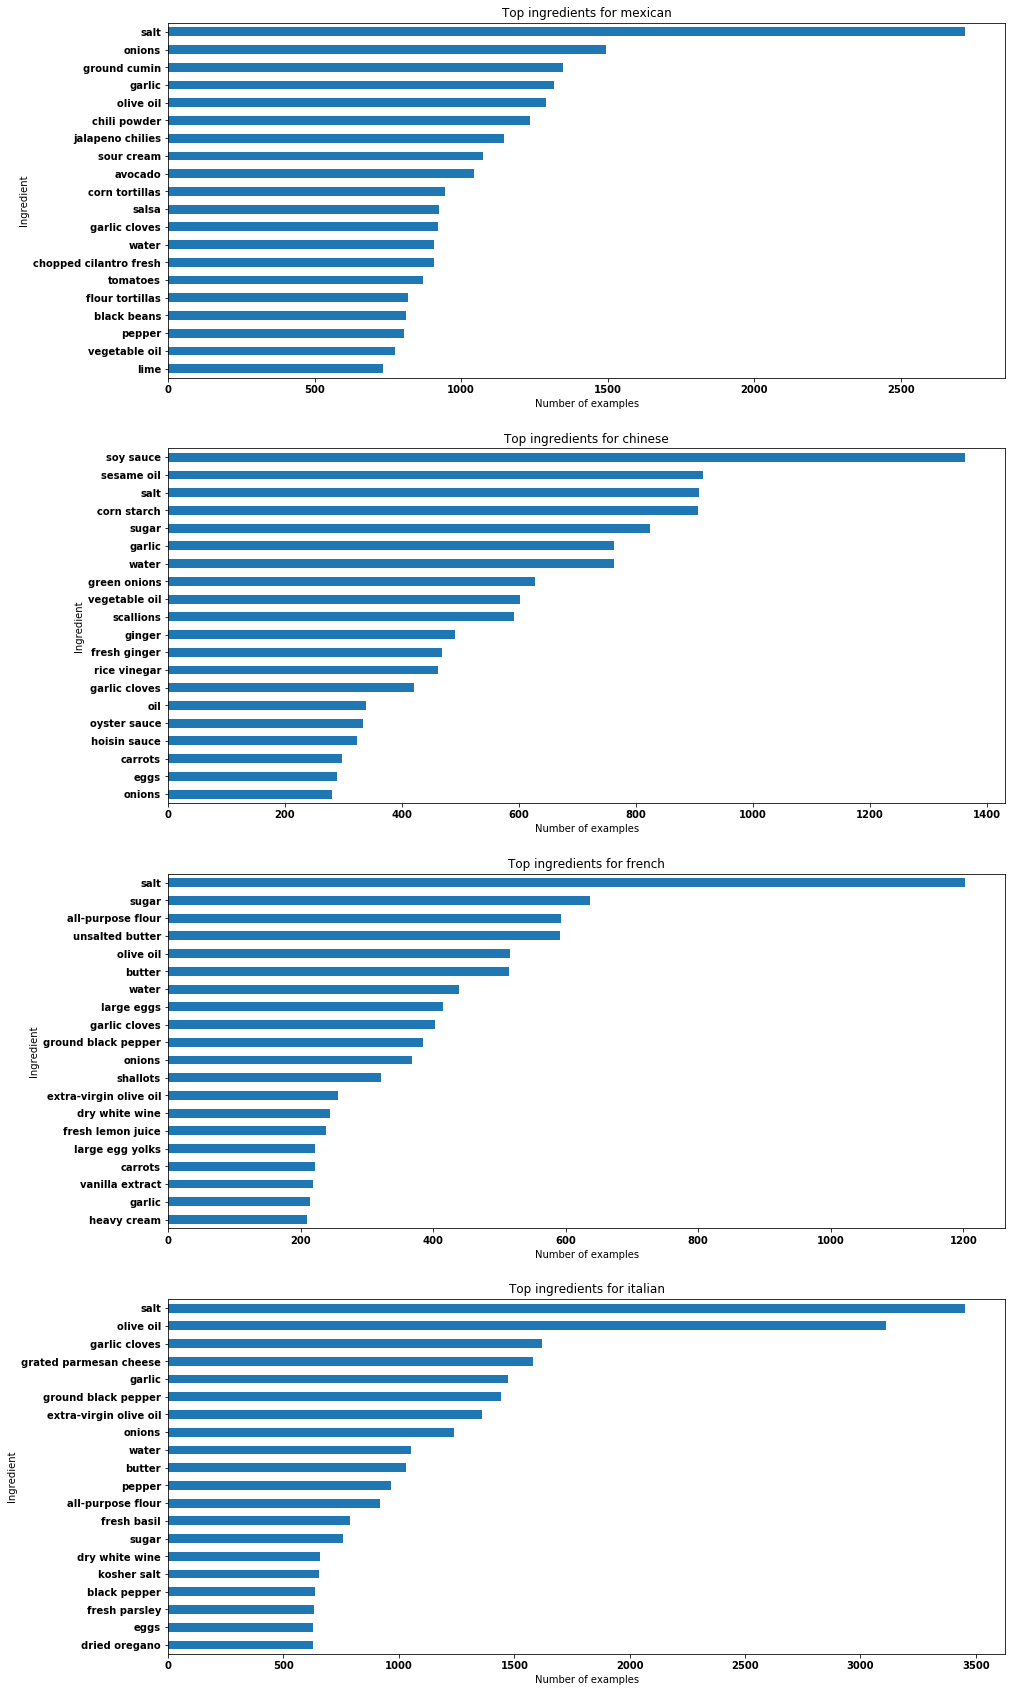

In [17]:
# Top ingredients by cuisine
plt.figure(figsize=(15,30))

grouped = ing_cuisine.groupby('cuisine')
cuisine_list = ['mexican', 'chinese', 'french', 'italian']

cuisines = grouped.groups.keys()
j = 0
for i in range(len(cuisines)):
    if cuisines[i] not in cuisine_list:
        continue

    plt.subplot(len(cuisine_list), 1, j+1)
    j+=1
    
    f = ing_cuisine[ing_cuisine['cuisine'] == cuisines[i]]['ingredient'].value_counts()[:20].plot(kind='barh')
    f.invert_yaxis()
    plt.title("Top ingredients for %s" % cuisines[i])
    plt.ylabel("Ingredient")
    plt.xlabel("Number of examples")
    i+=1

plt.show()

#### Least Common Ingredients - All Cuisines

There are also a long tail of uncommon ingredients in the data. Many of these tail ingredients seem to be just common ingredients (e.g. jack cheese) with additional modifiers (e.g. reduced fat). Below is an extreme case where the ingredient "one third less sodium chicken broth" really should just be chicken broth. One approach we want to look into is to find a systemmatic way of removing these modifies and normalizing them to the more common ingredients, which should reduce the total number of unique ingredients.

In [19]:
pd.DataFrame(ing_cuisine['ingredient'].value_counts()[-15:])

,ingredient
Crystal Farms Reduced Fat Shredded Marble Jack Cheese,1
chile piquin,1
fiddlehead ferns,1
jamaican jerk,1
butternut,1
chestnut spread,1
one third less sodium chicken broth,1
low sodium cajun seasoning,1
non-dairy margarine,1
wood mushrooms,1


## Data Preparation

Preparation steps here are common across all the models we used, and these training and dev sets will be reused for each of the models.

In [9]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train_all, y_train_all, random_state=2)

In [21]:
print "The shape of X_train is", X_train.shape
print "The shape of X_dev is ", X_dev.shape
print "The shape of y_train is", y_train.shape
print "The shape of y_dev is", y_dev.shape

The shape of X_train is (29830,)
The shape of X_dev is  (9944,)
The shape of y_train is (29830,)
The shape of y_dev is (9944,)


In [22]:
def list_to_string(l):
    return '|'.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

## Baseline Model

#### Training

For the baseline model, we are starting with a very simple logistic regression model with no hyperparameter tuning. We will also be using a very basic count vectorizer. The goal of this is really to establish a baseline and understand what the metrics are for this very basic model. Note that no class balancing is done here for the baseline model. This will be explored in a subsequent section.

In [24]:
base_pipeline = Pipeline(steps=[
    ('countvectorizer', CountVectorizer(binary=True)),
    ('lr', LogisticRegression()),
])
base_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#### Evaluation

In [26]:
print "Accuracy of the base model is", base_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is 0.776448109413


#### Error Analysis
From the confusion matrix, it can be seen that the baseline model confuses French and Italian cuisines considerably.

Text(0.5,1,u'Confusion matrix for the baseline model')

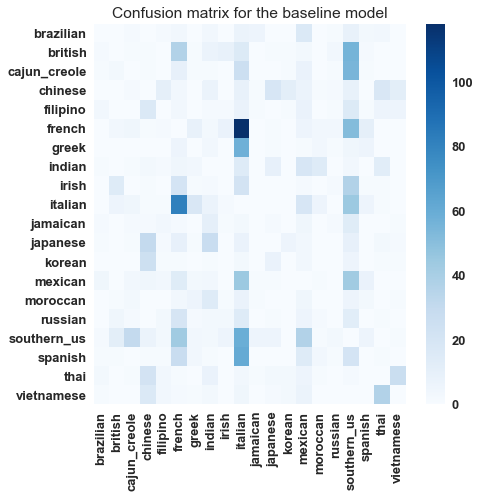

In [33]:
y_pred = base_pipeline.predict(X_dev_str)
cm = confusion_matrix(y_dev, y_pred)
np.fill_diagonal(cm, 0)
cm_df = pd.DataFrame(cm, index=base_pipeline.classes_, columns=base_pipeline.classes_)

plt.figure(figsize=(7,7))
sn.set(font_scale=1.3)
ax = sn.heatmap(cm_df, cmap="Blues")
plt.title("Confusion matrix for the baseline model")

One aspect of the model that is useful to explore is the confidence of each classification. We can use this information to detect which recipe's our model was very confident about, and which ones it was deciding between several options.

In [35]:
# Calculate confidence in classification and actual class probability
df_probs = pd.DataFrame(base_pipeline.predict_proba(X_dev_str), columns=base_pipeline.classes_)
df_probs['ingredients'] = X_dev.reset_index(drop=True)
df_probs['class'] = y_dev.reset_index(drop=True)
df_probs['prediction'] = base_pipeline.predict(X_dev_str)
df_probs['confidence'] = np.max(base_pipeline.predict_proba(X_dev_str), axis=1)
df_probs['class_prob'] = df_probs.apply(lambda row: row[str(row['class'])], axis=1)
df_probs['R'] = df_probs['confidence']/df_probs['class_prob']
df_probs['correct'] = df_probs['class'] == df_probs['prediction']
df_probs = df_probs[['ingredients', 'correct', 'class', 'class_prob', 'prediction', 'confidence', 'R']]

Looking at the incorrectly classified examples where the *R* metric is smallest, we can see examples where the model almost predicted the right class and was simply choosing between two good options. We can see this in the first example where it barely picked Thai over Indian, likely due to the coconut milk. Also, the last dish in the list below is clearly a recipe for bread, which is difficult to discern as the ingredients are fairly standard across different cusines.

In [37]:
keep_cols = ['class','prediction','class_prob','confidence','ingredients']
df_probs[~df_probs['correct']].sort_values('R')[keep_cols].head(7)

,class,prediction,class_prob,confidence,ingredients
7289,indian,moroccan,0.335793,0.336050,"[curry powder, sandwich buns, lemon juice, black pepper, cooking spray, bulgur, raita, ground cinnamon, sun-dried tomatoes, salt, ground lamb, fat free less sodium chicken broth, lettuce leaves, garlic cloves, ground cumin]"
8472,southern_us,french,0.293979,0.294339,"[wheat bread, apples, water, brown sugar, salted butter]"
2576,chinese,thai,0.481843,0.482433,"[curry powder, crushed red pepper flakes, oyster sauce, straw mushrooms, green onions, peanut oil, boneless skinless chicken breast halves, soy sauce, water chestnuts, peanut butter, noodles, fresh ginger, garlic, carrots]"
2704,italian,moroccan,0.321248,0.321937,"[ground ginger, ground cloves, raisins, dried fig, prunes, honey, salt, ground cinnamon, hazelnuts, Dutch-processed cocoa powder, sugar, almonds, all-purpose flour]"
7017,indian,filipino,0.296222,0.296964,"[garlic, onions, pepper, oil, cayenne, carrots, tumeric, salt, curry leaf]"
231,italian,french,0.383779,0.384752,"[butter, unsweetened cocoa powder, coffee granules, all-purpose flour, half & half, confectioners sugar, vanilla extract]"
6471,italian,french,0.383779,0.384752,"[half & half, confectioners sugar, coffee granules, all-purpose flour, vanilla extract, butter, unsweetened cocoa powder]"


Similarly, we can view the samples that it got very wrong and see which features may have convinced it to classify incorrectly with such confidence. In the first example below, *jalapeno chilies, adobe* and *Mexican oregano* all make this seem pretty convincingly a Mexican dish. In fact, we were not totally convinced that this isn't a Mexican dish that was incorrectly labeled.

In [38]:
pd.set_option('display.max_colwidth', -1)
keep_cols = ['class','prediction','class_prob','confidence','ingredients']
df_probs[~df_probs['correct']].sort_values('R', ascending=False)[keep_cols].head(5)

,class,prediction,class_prob,confidence,ingredients
3095,chinese,mexican,0.000024,0.925151,"[suckling pig, bay leaves, worcestershire sauce, salt, lard, white onion, jalapeno chilies, raisins, red bliss potato, carrots, green apples, tomatoes, ground black pepper, Mexican oregano, fresh orange juice, pimento stuffed olives, fresh lime juice, adobo, fresh thyme, cinnamon, garlic, juice, fresh pineapple]"
6150,irish,italian,0.000025,0.539158,"[olive oil, long-grain rice, water, zucchini, sliced mushrooms, fresh basil, beef, garlic cloves, yellow squash, chopped onion, plum tomatoes]"
7718,spanish,russian,0.000041,0.648813,"[warm water, honey, port, walnuts, ground cinnamon, molasses, unsalted butter, all-purpose flour, sugar, active dry yeast, large eggs, candied fruit, ground ginger, ground cloves, baking soda, salt, dried cranberries]"
9643,filipino,mexican,0.000070,0.714625,"[vegetable oil, minced beef, ground cumin, beef, extra-virgin olive oil, smoked paprika, boiled eggs, Italian parsley leaves, garlic cloves, chili powder, yellow onion, oregano leaves]"
7733,filipino,mexican,0.000138,0.689964,"[lime juice, green onions, boneless skinless chicken breast halves, olive oil, fresh oregano, fresh cilantro, salt, ground cumin, pepper, fresh thyme, garlic cloves]"


The calibration curve below shows that logistic regression is slightly overconfident when making it's predictions. It's typically overconfident by 5-10%.

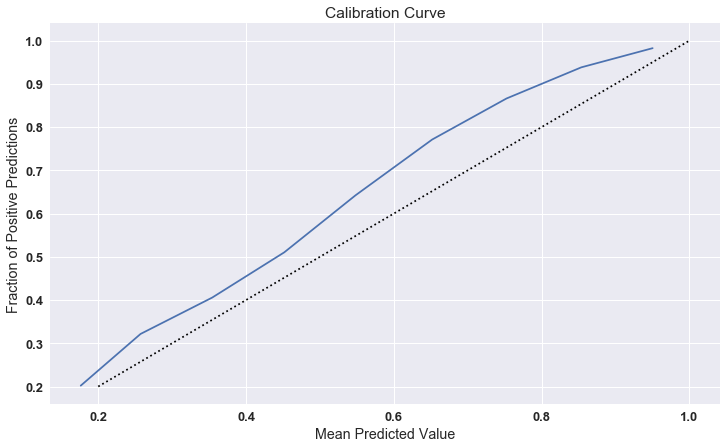

In [40]:
from sklearn.calibration import calibration_curve
frac_of_pos, mean_pred_val = calibration_curve(df_probs['correct'], df_probs['confidence'], n_bins=10)
plt.figure(figsize=(12,7))
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positive Predictions')
plt.plot([0.2, 1], [0.2, 1], "k:")
plt.plot(mean_pred_val, frac_of_pos);

## Additional Feature Engineering

#### Broadmatch Technique

To address the problem of normalizing the long, "uncommon" ingredients like "one third less sodium chicken broth" to just "chicken broth", we feel this will improve model performance, since if an ingredient in the test set has not been seen before from the training set, then that ingredient has no predictive power. That said, the ingredient may just have been a common ingredient with a unique modifier term.

Here we introduce a technique called "broadmatching" where we take each ingredient and recurisively drop terms to see if the resulting substring is a more common ingredient than the original ingredient. To assess what is more "common", we leverage the training set to look at how many recipes contain the ingredient. E.g. "salt" would have a high num_recipes where as "finely grounded sea salt" would have a low num_recipes.

In [50]:
# Helper function for normalizing strings
def normalize(s):
    lm = WordNetLemmatizer()
    printable = string.printable
    PERMITTED_CHARS = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ " 

    filter(lambda x: x in printable, s)
    s = "".join(c for c in s if c in PERMITTED_CHARS)
    s = lm.lemmatize(s.lower())

    return s 

# Build a list of ingredients across all recipes (used for counting later)
ingredient_list = []
i = 0
for ingredients in X_train_str:
    for ingredient in ingredients.split(' '):
        ingredient_list.append(normalize(ingredient.replace('_', ' ')))
        
# Flatten the list to an ingredient - count table, to be used for broadmatching
ing_counts = pd.DataFrame(ingredient_list, columns=['num_recipes']).num_recipes.value_counts()
ing_df = pd.DataFrame(ing_counts)
ing_df.index.names = ['ingredient']

# Given an ingredient, return all subsets of the ingredient string as a list of strings
def get_substrings(ingredient):
    # Base case - Return an empty list of the string is empty
    if ingredient == '':
        return []
    
    word_list = ingredient.split(' ')
    substring_list = []
    substring_list.append(ingredient)
    
    # Base case - Return a list with only the ingredient if there is only one word
    if len(word_list) == 1:
        return substring_list
    
    # Recursive Case    
    for i in range(len(word_list)):
        new_list = np.array(word_list, copy=True).tolist()
        new_list.remove(word_list[i])
        substring_word = ' '.join(new_list)
        substring_list.append(substring_word)
        
        sub_list = get_substrings(substring_word)
        for w in sub_list:
            substring_list.append(w)

    return substring_list

# Dedupes the output list of get_substrings function
def get_substrings_deduped(substring_list):
    return np.unique(get_substrings(substring_list)).tolist()

def broadmatch(ing):
    if len(ing.split(' ')) > 10:
        return ing
    
    df = pd.DataFrame(get_substrings_deduped(ing), columns=['ingredient']).set_index('ingredient')
    joined_df = df.join(ing_df, lsuffix = 'l', rsuffix='r')
    
    normalized_ingredient = joined_df['num_recipes'].idxmax()
    return normalized_ingredient if not type(normalized_ingredient) == float else ing

In [51]:
# Finding the broadmatched ingredient for each unique ingredient, storing in a dataframe as a look-up table
# Note: This code takes quite a bit of time to compute
norm_ing_arr = []
for i in range(len(ing_df.index)):
    norm_ing_arr.append([ing_df.index[i], broadmatch(ing_df.index[i])])
    
norm_ing_df = pd.DataFrame(norm_ing_arr, columns = ['Original Ingredient', 'Broadmatched Ingredient'])
norm_ing_df.head(10)

,Original Ingredient,Broadmatched Ingredient
0,salt,salt
1,onion,onion
2,olive oil,olive oil
3,water,water
4,garlic,garlic
5,sugar,sugar
6,garlic cloves,garlic
7,butter,butter
8,ground black pepper,ground black pepper
9,allpurpose flour,allpurpose flour


#### Broadmatch Analysis
Broadmatching seems to have greatly reduced the number of unique ingredients in the training data. This shows good signs that broadmatching was able to deduplicate tail ingredients to more common ingredient.

In [52]:
print "Number of unique ingredients before broadmatching %d" % norm_ing_df['Original Ingredient'].unique().shape
print "Number of unique ingredients after broadmatching %d" % norm_ing_df['Broadmatched Ingredient'].unique().shape

Number of unique ingredients before broadmatching 6224
Number of unique ingredients after broadmatching 2187


Below are a few examples where broad matching tends to do really well. In these cases, dropping terms led to finding a more common ingredient that would be more relevant for training purposes.

In [54]:
print "Good examples:"
print "frozen lemonade concentrate thawed and undiluted --> %s" % broadmatch("frozen lemonade concentrate thawed and undiluted")
print "tomato sauce low sodium --> %s" % broadmatch("tomato sauce low sodium")
print "johnsonville hot  spicy sausage slices --> %s" % broadmatch("johnsonville hot  spicy sausage slices")
print "new mexico red chile powder --> %s" % broadmatch("new mexico red chile powder")
print "raw peeled prawns --> %s" % broadmatch("raw peeled prawns")

Good examples:
frozen lemonade concentrate thawed and undiluted --> frozen lemonade concentrate
tomato sauce low sodium --> tomato
johnsonville hot  spicy sausage slices --> sausage
new mexico red chile powder --> chile
raw peeled prawns --> peeled prawns


That said, there are also some examples where broadmatching does not tend to work well. In some cases, broadmatching was too aggressive, where the broadmatched ingredient was too common. In other cases, a relevant term gets dropped, in which case the actually ingredient changed after broadmatching. From inspection, it does look like broadmatching works well in more cases than not work well.

In [55]:
print "Bad examples:"
print "condensed cream of broccoli soup --> %s" % broadmatch("condensed cream of broccoli soup")
print "orange pekoe tea --> %s" % broadmatch("orange pekoe tea")
print "whole wheat pita pockets --> %s" % broadmatch("whole wheat pita pockets")
print "garlic herb spreadable cheese --> %s" % broadmatch("garlic herb spreadable cheese")
print "reduced sodium beef stock --> %s" % broadmatch("reduced sodium beef stock")

Bad examples:
condensed cream of broccoli soup --> cream
orange pekoe tea --> orange
whole wheat pita pockets --> pita
garlic herb spreadable cheese --> garlic
reduced sodium beef stock --> beef


#### Adding Broadmatch to the Baseline Model

In [56]:
# Convert the look-up table to a dictionary for the actual look-up
bm_dict = {}
for i, row in norm_ing_df.iterrows():
    bm_dict[row['Original Ingredient']] = row['Broadmatched Ingredient']
    
def broadmatch_string(s):
    final_ing_list = []
    for ing in s.split(' '):
        ing = ing.replace('_', ' ')
        if ing in bm_dict:
            ing = bm_dict[ing]
        final_ing_list.append(ing.replace(' ', '_'))
    
    return ' '.join(final_ing_list)

# Create a broadmatch function to be used for the pipeline
def broadmatch_X(X, turn_on):
    if turn_on == True:
        return X.apply(broadmatch_string)
    else:
        return X

In [60]:
broadmatch_pipeline = Pipeline(steps=[
    ('broaddmatch', FunctionTransformer(broadmatch_X, validate=False, kw_args={ "turn_on" : True })),
    ('countvectorizer', CountVectorizer(binary=True, min_df=10)),
    ('lr', LogisticRegression()),
])
broadmatch_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('broaddmatch', FunctionTransformer(accept_sparse=False,
          func=<function broadmatch_X at 0x1a1b210668>, inv_kw_args=None,
          inverse_func=None, kw_args={'turn_on': True},
          pass_y='deprecated', validate=False)), ('countvectorizer', CountVectorizer(analyzer=u'word', bin...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [61]:
print "Accuracy of the base model is", broadmatch_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is 0.752312952534


Using broadmatching surprisingly led to a considerably lower accuracy. Looking at the confusion matrix (which we chose to exclude in this notebook), it is very similar to the confusion matrix for the baseline model. From additional analyses, we have found that broadmatching sometimes were too aggressive, and many ingredients broadmatched to very common ingredients, which further enhanced the problem of separating out cuisines based on only these common ingredients (e.g. salt, oil, etc.).

## Other Methods attempted

We ultimately found that SVM worked the best given our preprocessing choices. However, before examining that we will discuss some of the other metheods attempted.

#### __Bi-Gram & Tri-Gram Vectorization:__

We did attempt several vectorizations to test if they would work. Though we were skeptical of it, we did try to use n-gram vectorization and removed the preprocessing step where we combined the entire ingredient into one string. This was ultimately ineffective for bigrams and higher. Even when using a minimum document frequency parameter to filter out noise, it created a large noisy vectorization of the problem. For instance, if you had the following ingredients *sugar, salted butter, low fat milk* you would get the following features (*sugar salted, salted butter, butter low, low fat, fat milk*). As suspected this vectorization scheme was unsuccessful and we ultimately went with a basic one word vectorizer.


#### __Naive Bayes:__

We tried using a Naive Bayes approach to try and identify the recipes, because Naive bayes has a good track record with text classification. The fact that Naive Bayes assumes independence allows for it to steer clear of the trap of overfitting that is common with high dimensional problems. 

However, after attempting to run it with several different vectorizations it proved to ultimately perform worse than our baseline model, with an accuracy of 0.75 and lower precision and recall scores. Logistic regression may have proved to be a better option since there are so few ingredients for each recipe and the interaction between variables can be very important. For instance, rice is a fairly generic ingredient and not all that informative on its own. However, rice with corriander may be more highly associated with indian food in comparison to rice with coconut milk. The Naive Bayes method did prove to have less overfitting, but ultimately sacrificed accuracy.

#### __Clustering Ensemble:__

Another method we tried was to group the recipes into distinct clusters and then fit an SVM on each one. The idea behind this is that you may have several clusters that are similar to one another that can be linearly separated by a classifier trained specifically on that cluster as opposed to coming up with on classifier which generalizes well to each cluster. 

This method also proved worse than our baseline. While it did perform very well on several of the clusters it managed to group many of the poor performing groups together. The several clusters had an 85% accuracy while the worst performing cluster was 60%. While this method did not improve performance it did show that there was a correlation between the performance of the various models and the number of ingredients within each recipe. The clustering method seemed to group the recipes into those with many ingredients and those with fewer ingredients. Those with fewer ingredients always performed worse. 

This shows how our initial inclination to reduce the feature space using the broadmatch method and combining the ingredients into a single token may have been misguided. It also shows how using the single word vectorization may have boosted the density of the feature space and ultimately increased the performance

#### __XGBoost:__

We attempted to use the XGBoost package, because of its track record solving a variety of problems. It also does a better job of trying to solve the problem we were trying to address with clustering. After correctly classifying several examples, it will focus on the samples that it gets wrong and try to get them right. It also employs a degree of regularization to avoid overfitting and keeping the model generalizable. 

Unfortunatley, this method did not perform well either. After tuning hyperparameters, the best performance we were able to get was 75%. 

## SVM

#### Training

For the final model we introduce several new components. A slightly updated preprocessing step, a TF-IDF vectorization, and a linear support vector machine (SVM). 

The new preprocessing step uses the learning from the clustering method that potentially boosting the number of features will increase the performance of our model. For our final model, we stopped grouping ingredients into one token such as *low_fat_milk* and instead use single word tokens and strip out the special characters and numbers. 

The TF-IDF vectorizer is a way of downweighting common samples and upweighting rare samples. There are two major components to this vectorization, term-frequency which counts how often the term shows up in the document, and inverse-document-frequency which calculates how many documents out of the corpus contain that particular term. The term-frequency does not factor in for this particular problem as we are tokenizing each ingredient individually, and no ingredient will appear in a recipe more than once. However, the inverse document frequency is useful for downweighting the ingredients that appear in many recipes, such as *salt*, *water*, etc.

The final algorithm that we chose to go with was a Linear SVM. SVM's are good at finding linear and non-linear boundaries for classification. Another reason we decided to try it is that it generalizes better than logistic regression does. We chose a Linear SVM, due to the high dimensionality of the problem we are training. However, we did test our problem with other kernels to verify that a linear SVM was the correct choice.

In [10]:
# Preprocess data by removing special characters and grouping each ingredient separately
def list_to_string(l):
    l = [re.sub('[^A-Za-z]',' ',x).strip() for x in l]
    return ', '.join(l)

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

In [11]:
# Import the necessary models for SVM and TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

svc_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(ngram_range=(1,1))),
    ('svm', LinearSVC(penalty='l2', C=0.625)),
])

svc_pipe.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

#### Evaluation

The accuracy has improved by nearly 1%. Also, as would be expected, there is considerably less overfitting with the LinearSVC as it finds the best decision boundary possible and generalizes better to new data. 

In [13]:
print("Accuracy of the base model on the training data is", svc_pipe.score(X_train_str, y_train))
print("Accuracy of the base model on the dev data is", svc_pipe.score(X_dev_str, y_dev))

Accuracy of the base model on the training data is 0.85719074757
Accuracy of the base model on the dev data is 0.785599356396


From our high level accuracy methods it seems that the Linear SVC slightly outperformed the logistic regression model. Our precision, recall, and f1-score all showed slight improvement which is a better indicator to use when assessing multiple classes. This shows that overall the SVM did improve the overall results. This may be because the SVM will not only find a decision boundary, but it will typically find the best decision boundary and therefore generalizes better to new data.

In [14]:
y_pred = svc_pipe.predict(X_dev_str)
print ("Precision of the base model is", precision_score(y_dev, y_pred, average='macro') )
print ("Recall of the base model is", recall_score(y_dev, y_pred, average='macro') )
print ("F1 of the base model is", f1_score(y_dev, y_pred, average='macro') )

Precision of the base model is 0.748286492907
Recall of the base model is 0.674152208756
F1 of the base model is 0.703115888822


#### Confusion Matrix

As seen in the confusion matrix below, we still have much confusion between Italian and French. This problem persists as there are many overlapping ingredients used often in the cuisine of both nations. Also, *southern_us* is predicted more often than it should be with this model. An attempt to account for this with balanced classes was used, but proved ultimately unsuccessful as it was with logistic regression. 

Unfortunately, the LinearSVC model does not provide the probabilities for the predictions, so we are unable to analyze the calibration of the final model.

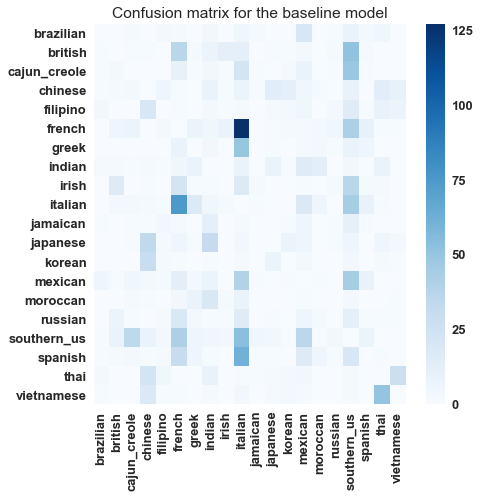

In [70]:
cm = confusion_matrix(y_dev, y_pred)
np.fill_diagonal(cm, 0)
cm_df = pd.DataFrame(cm, index=base_pipeline.classes_, columns=base_pipeline.classes_)

plt.figure(figsize=(7,7))
sn.set(font_scale=1.3)
ax = sn.heatmap(cm_df, cmap="Blues")
plt.title("Confusion matrix for the baseline model");

## Conclusion

In summary, the best performing model was a linear SVM model with TF-IDF vectorization and no broadmatching or additional feature-engineering techniques with an accuracy of 78.6%.

Here are some other models and techniques we have tried, with their corresponding accuracies (for those that are worth mentioning):

* Baseline - 77.6%
* Baseline with broadmatching - 75.2%
* Baseline with N-gram vectorization 76%
* Naive bayes - 75%
* Clustering ensemble - 74%
* XGBoost - 75%

There were several methods that we considered trying, but did not have the time to implement. One method was to use python's TextBlob package to potentially filter out certain parts of words. Another method would be to scroll over each word in the ingredient list and detect the individual language. Language could provide a good indication when ingredients are fairly similar, or if there are some ingredients that are rare in the overall corpus such as *miso* a japanese soup. Another potential improvement could be to run a spell checking algorithm to improve overall matches.

Through inspection, broadmatching seems to show good promise, although there were cases where broadmatching was too aggressive. We think that introducing some threshold on how much to broadmatch would prevent such agressively-broadmatched cases. 

Another method that we did not get to implement was including the number of ingredients as a feature. The clustering ensemble method was performed late in the analysis, but did show that there was some potential for more ingredients contributing to better fit. Perhaps the some cuisines would use more ingredients and thus be easier to detect, such as indian recipes which have a considerable number of spices in them. We were not able to explore this as we ran out of time.

To take this challenge further, to accurately predict the correct cuisine, ideally we would love to have additional data along with the ingredients. As seen in our analysis, ingreidents alone may not have enough predictive signals to accurately predict a cuisine given that cuisines like French and Italian have highly overlapping ingredients. Additional data like instructions for cooking the recipe may help differentiate different cuisines. For example, cooking sous vide is very specific to French cooking, and boiling and simmering is more common with Italian cooking.